In [ ]:
%pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=0e930493fe1452af4e6e74c86a2fc82cef293d47589197b251e0ae5f2eede7bf
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [2]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import face_recognition

In [3]:
# function 
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))


In [5]:




varun_image = face_recognition.load_image_file("/content/sample_data/varun.jpg")
varun_face_encoding = face_recognition.face_encodings(varun_image)[0]

alok_image = face_recognition.load_image_file("/content/sample_data/alok.jpg")
alok_face_encoding = face_recognition.face_encodings(alok_image)[0]

vineet_image = face_recognition.load_image_file("/content/sample_data/vineet.jpg")
vineet_face_encoding = face_recognition.face_encodings(vineet_image)[0]

shashank_image = face_recognition.load_image_file("/content/sample_data/shashank.jpg")
shashank_face_encoding = face_recognition.face_encodings(shashank_image)[0]

kuldeep_image = face_recognition.load_image_file("/content/sample_data/kuldeep.jpg")
kuldeep_face_encoding = face_recognition.face_encodings(kuldeep_image)[0]



known_face_encodings = [
    
    varun_face_encoding,
    alok_face_encoding,
    vineet_face_encoding,
    shashank_face_encoding,
    kuldeep_face_encoding



]
known_face_names = [
    
    "varun,verified ",
    "alok sir,verified",
    "vineet sir,verified",
    "shashank,verified",
    "kuldeep sir,verified"
]

In [6]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # 
  #
  #
  face_locations = face_recognition.face_locations(img)
  face_encodings = face_recognition.face_encodings(img, face_locations)
  # 
  #
  for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
    name = "Unknown"
    face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]:
      name = known_face_names[best_match_index]
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
    cv2.rectangle(img, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img, name, (left - 2, bottom - 6), font, 1.0, (255, 255, 255), 1)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
      #img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


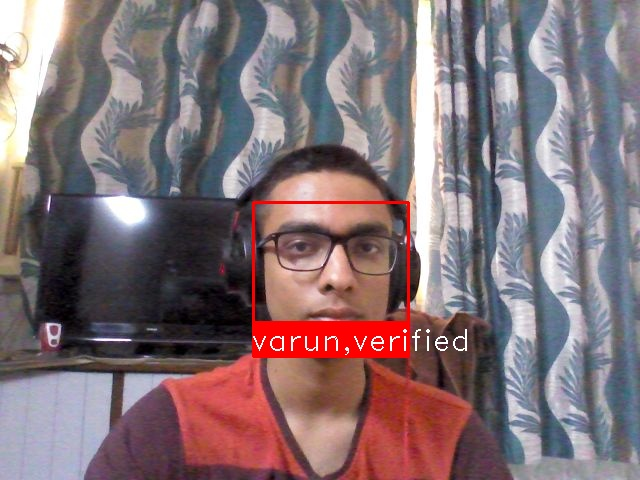

In [7]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))